## DSS Worshop: Synthetic Data Generation With SDV
Data privacy is increasingly becoming an important consideration when we tackle any data science use-case. In order to comply with regulation and still innovate and create value, Privacy Enhancing Techniques (PETs) are worth considering. For a broad overview of PETs, we invite you to follow our sub-community in DS4A and check out our wiki and our past talks. If you are interested in PETs and would like to contribute with ideas, talks, questions, use-cases or introduce us to a cool technique you have seen somewhere, you are the most welcome !

Synthetic data generation is one of the hottest PETs, so this workshop aims to introduce synthetic data generation using the Synthetic Data Vault library (https://sdv.dev/). We will explore together an example of synthetic data generation on a simple insurance dataset. First, we will load an visualize our dataset. Then, we will test the following synthetic data generation models:
- Gaussian Copula
- CTGAN
- TVAE

### Guidelines for the workshop
- We recommend that you complete this workshop using Colab, you can use your favorite notebook environment if you wish, but we won't be able to help with errors due to environment settings
- You will have sections marked **TO DO** that contain comments `#Your code` for you to fill in. You will be given time to complete the sections and we will discuss together. The instructions will be explained before each exercise.
- At any given moment, you can ask questions. **Please interreupt the speaker if you are unable to run the notebook**. You can also use the chat to ask questions and we will read the questions.

**!!! SKIP IF ALREADY EXECUTED !!!**

In [ ]:
!pip install matplotlib==3.1.3
!pip install sdv
!pip install seaborn --upgrade

**!!!!!!!!!!!!!!!!!!!!!!!!!!!!**

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sdmetrics.reports import utils
from sdmetrics.reports.single_table import QualityReport
from sdv.lite import TabularPreset
from sdv.tabular import CTGAN, GaussianCopula, TVAE, CopulaGAN
from sdv.evaluation import evaluate

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Load and visualize the dataset

In [3]:
url = 'https://raw.githubusercontent.com/oumasab/dss-workshop/main/insurance.csv'
df = pd.read_csv(url)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#### Define metadata for the dataset - will be needed later to evaluate the synthetic data

In [3]:
metadata = {
    "fields": {
        "age": {
            "type": "numerical",
            "subtype": "integer"
        },
        "sex": {
            "type": "categorical"
        },
        "bmi": {
            "type": "numerical",
            "subtype": "float"
        }, 
        "children": {
            "type": "numerical",
            "subtype": "integer"
        },
        "smoker": {
            "type": "categorical"
        },
        "region": {
            "type": "categorical"
        },
        "charges": {
            "type": "numerical",
            "subtype": "float"
        }
    }
}

#### Display the dataset using seaborn.pairplot()
**TO DO:** Let's modify the variable `hue` to visualize data's dependence on the categorical variables

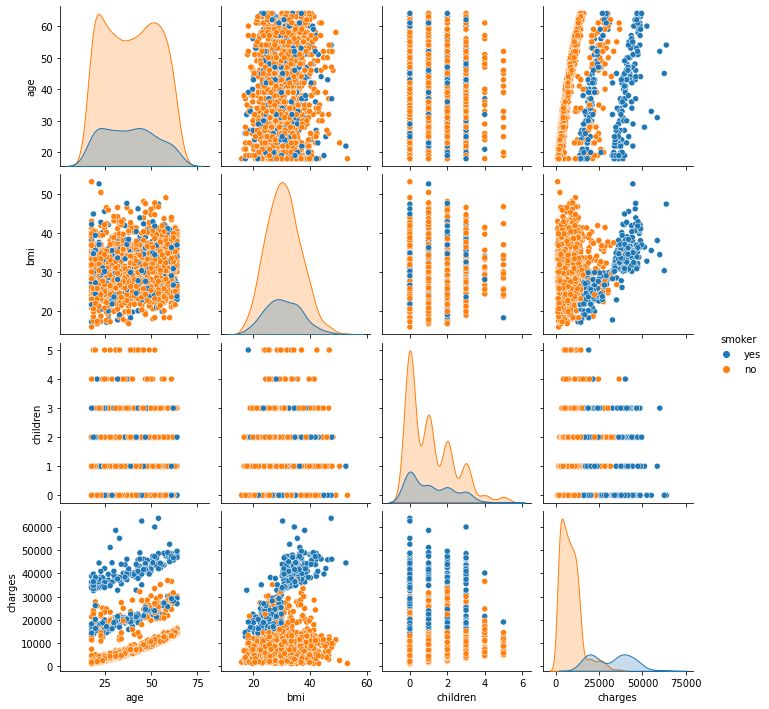

In [172]:
sns.pairplot(data=df, hue="smoker")
plt.show()

### First attempt at Synthetic data generation
Let's generate a first version of synthetic data. Here, we will use the models directly on our dataset without any additional feature engineering.

#### Quick usage of SDV models
Nothing is easier than getting started with SDV models. All you have to do is to follow these steps:
1. Load your dataset as Pandas `DataFrame`
2. (Optional, but recommended for the Tabular Preset) Define you dataset's metadata (description of column types)
3. Initialize the model
4. Use the `fit()` method
5. Sample new data using the `sample()` method

#### Tabular Preset
The `TabularPreset` is a tabular model that comes with pre-configured settings. This is meant for users who want to get started with using synthetic data and spend less time worrying about which model to choose or how to tune its parameters.
The `FAST_ML` preset uses machine learning (ML) to model your data while optimizing for the modeling time. This is a great choice if it’s your first time using the SDV for a large custom dataset or if you’re exploring the benefits of using ML to create synthetic data.

In [9]:
model_fastml = TabularPreset(name='FAST_ML', metadata=metadata)
model_fastml.fit(df)

In [10]:
df_fastml = model_fastml.sample(1400)

**Let's visualize the synthetic data**

**TO DO:** Visualize the synthetic data using `sns.pairplot()`

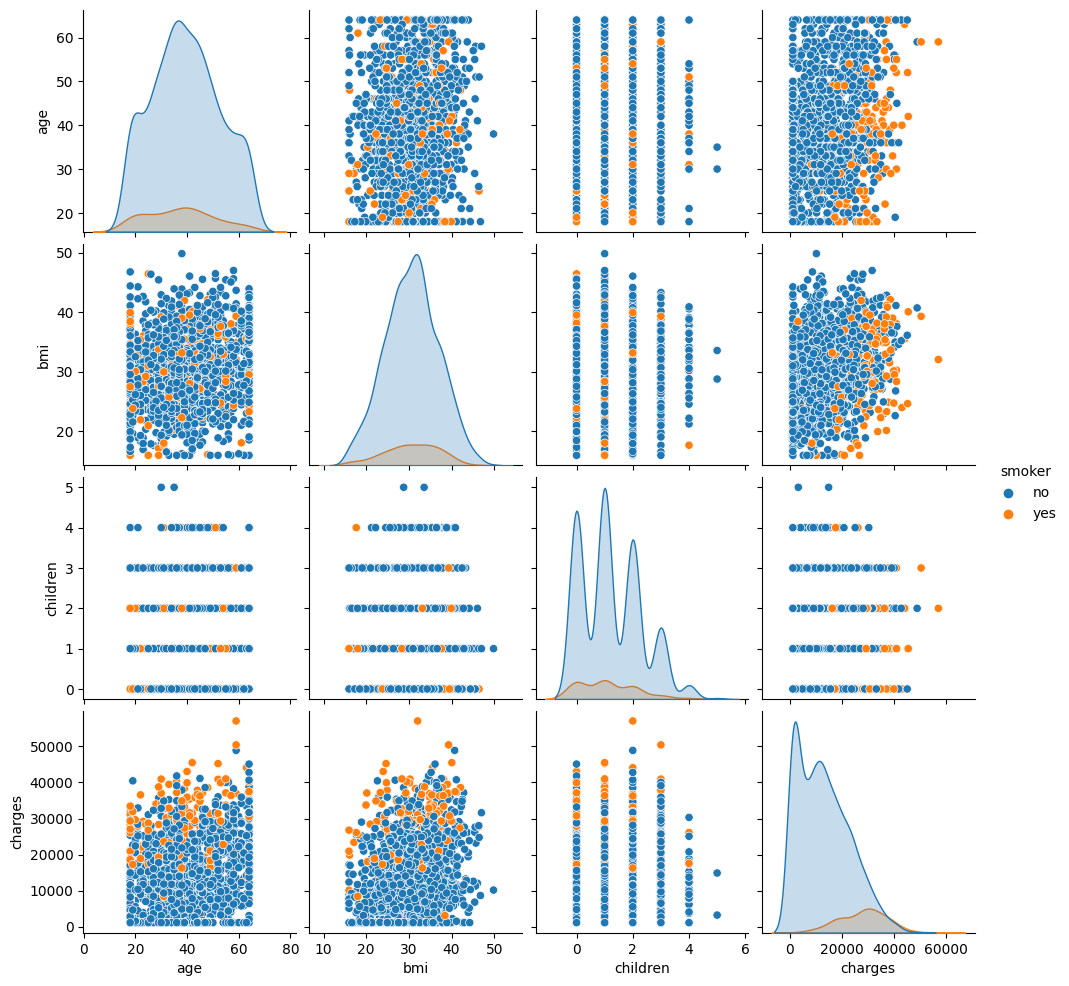

In [11]:
sns.pairplot(data=df_fastml, hue="smoker")
plt.show()

#### Gaussian Copula
The `sdv.tabular.GaussianCopula` model is based on copula funtions.

In mathematical terms, a copula is a distribution over the unit cube $[0,1]^{𝑑}$ which is constructed from a multivariate normal distribution over $ℝ^{𝑑}$ by using the probability integral transform. Intuitively, a copula is a mathematical function that allows us to describe the joint distribution of multiple random variables by analyzing the dependencies between their marginal distributions. 

In order to "learn" the original dataset, the `GaussianCopula()` model performs the following steps:

1. Learn the format and data types of the passed data

2. Transform the non-numerical and null data using Reversible Data Transforms to obtain a fully numerical representation of the data from which we can learn the probability distributions.

3. Learn the probability distribution of each column from the table

4. Transform the values of each numerical column by converting them to their marginal distribution CDF values and then applying an inverse CDF transformation of a standard normal on them.

5. Learn the correlations of the newly generated random variables.

After this, in order to generate the synthetic dataset using the trained model, the following steps are performed:

1. Sample from a Multivariate Standard Normal distribution with the learned correlations.

2. Revert the sampled values by computing their standard normal CDF and then applying the inverse CDF of their marginal distributions.

3. Revert the RDT transformations to go back to the original data format.


In [134]:
model_gaussian = GaussianCopula()
model_gaussian.fit(df)

In [135]:
df_gaussian = model_gaussian.sample(1400)

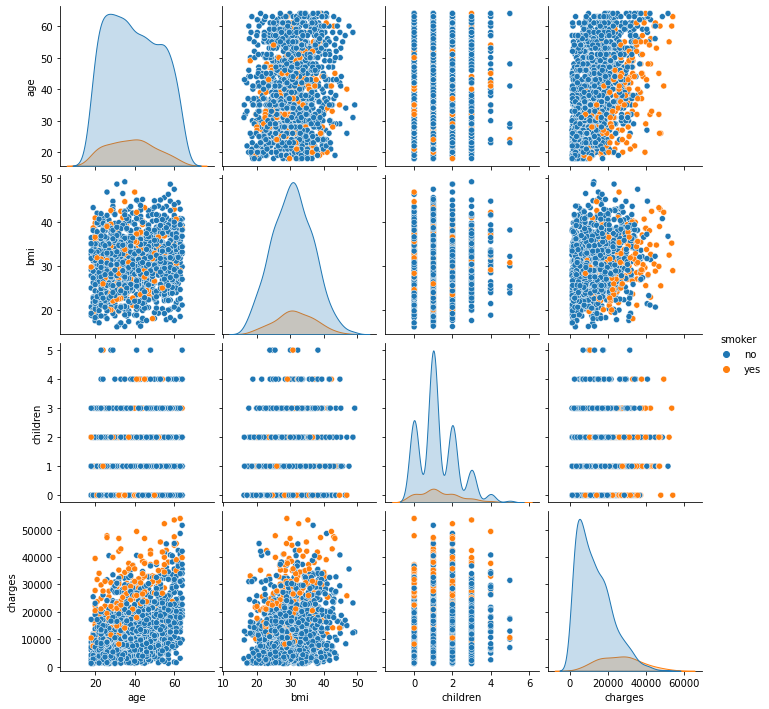

In [136]:
sns.pairplot(data=df_gaussian, hue="smoker")
plt.show()

#### CTGAN
The `sdv.tabular.CTGAN` model is based on the GAN-based Deep Learning data synthesizer which was presented at the NeurIPS 2020 conference by the paper titled Modeling Tabular data using Conditional GAN.

A few details about CTGAN:
- GAN-based method to sample from the distribution of the input data
- This method is more adapted to deal with class imbalance in categorical variables as the Generator uses training-by-sampling
- Both the Generator and Discriminator are fully connected networks, which allows to capture all correlations between features
- CTGAN achieves Differential Privacy as the CTGAN Generator never accesses the real data throughout training

**TO DO:** Train then sample data from a CTGAN model. Visualize the result.

**Train a CTGAN model**

In [140]:
model_ctgan = CTGAN()
model_ctgan.fit(df)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f6376f5a700>
Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_itera

In [ ]:
df_ctgan = model_ctgan.sample(1400)

**Visualize the synthetic dataset**

In [ ]:
sns.pairplot(data=df_ctgan, hue="smoker")
plt.show()

#### TVAE
The `sdv.tabular.TVAE` model is based on the VAE-based Deep Learning data synthesizer which was presented at the NeurIPS 2020 conference by the paper titled Modeling Tabular data using Conditional GAN.

A few details about TVAE:
- An adaptation of VAE for tabular data: the encoder is adapted to work with tabular data, the decoder is kept as in classic VAE
- In a nutshell, TVAE (much like VAE) is composed of an encoder that transforms input to a latent space, then a decoder that samples new data from the latent space
- Unlike CTGAN, TVAE is not compatible with Differential Privacy

**TO DO:** Train then sample data from a TVAE model. Visualize the result.

In [ ]:
model_tvae = TVAE()
model_tvae.fit(df)
df_tvae = model_tvae.sample(1400)

In [ ]:
sns.pairplot(data=df_tvae, hue="smoker")
plt.show()

In [ ]:
model_tvae = TVAE()
model_tvae.fit(df)

In [ ]:
df_tvae = model_tvae.sample(1400)

**Visualize the generated dataset**

In [ ]:
sns.pairplot(data=df_tvae, hue="smoker")
plt.show()

#### Deep-dive into a few features
**Visualize the figure of charges w.r.t to age in the synthetic dataset and the real dataset in the same figure using `sns.scatterplot()`**

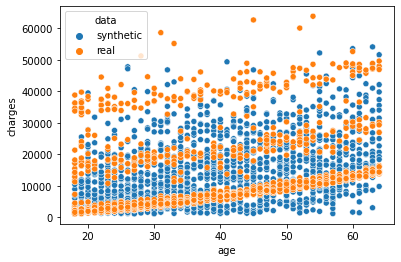

In [165]:
to_plot = df_gaussian[["age", "charges"]]
to_plot["data"] = "synthetic"
to_plot = pd.concat([to_plot, df[["age", "charges"]]])
to_plot.fillna("real", inplace=True)
sns.scatterplot(data=to_plot, x="age", y="charges", hue="data")
plt.show()

**Visualize the distributions of given features in the synthetic data using `sdmetrics.report.utils.get_column_plot()`**

**TO DO:** Change the parameter `column_name` to visualize different variables

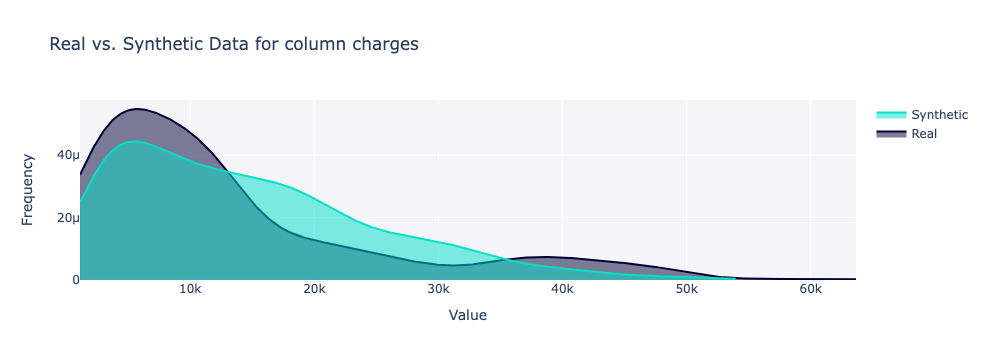

In [169]:
fig = utils.get_column_plot(
    real_data=df,
    synthetic_data=df_gaussian,
    column_name='charges',
    metadata=metadata
)

fig.show()

#### Evaluate the models
SDV offers two possibilities to evaluate the quality of synthetic data. 
- **Option 1:** Using `sdv.evaluation.evaluate`, which allows to compute a few similarity metrics
- **Option 2:** Using `sdmetrics.reports.single_table.QualityReport`, which is the newest model evaluation framework and allows to visualize quality metrics

**Evaluate similarity metrics**
- **Inverted Kolmogorov-Smirnov D statistic:** evaluates the similarity of distributions of continuous variables between the synthetic and real data
- **Chi-Squared:** evaluates the similarity of distributions of categorical variables between the synthetic and real data

In [137]:
columns = ["age", "sex", "bmi", "children", "smoker", "region", "charges"]
real_data = df[columns]
synthetic_data = df_gaussian[columns]

In [138]:
evaluate(real_data, synthetic_data, aggregate=False)

,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,KSComplement,Inverted Kolmogorov-Smirnov D statistic,0.883817,0.883817,0.0,1.0,MAXIMIZE,None
1,CSTest,Chi-Squared,0.942117,0.942117,0.0,1.0,MAXIMIZE,None


**Visualize the Quality report**
The quality report relies on two main metrics:
- **Total Variation Distance:** which evaluates the similarity between two discrete distributions (used for categorical variables)
- **Inverted Kolmogorov-Smirnov D statistic:** which evaluates the similarity between two continuous distributions

Creating report: 100%|██████████| 4/4 [00:00<00:00, 25.17it/s]



Overall Quality Score: 92.23%

Properties:
Column Shapes: 92.68%
Column Pair Trends: 91.77%


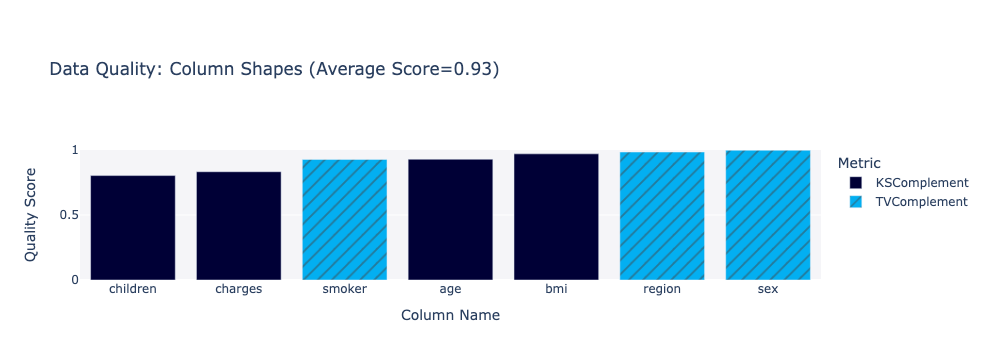

In [139]:
report = QualityReport()
report.generate(real_data, synthetic_data, metadata)
fig = report.get_visualization(property_name='Column Shapes')
fig.show()

In [163]:
report.get_details(property_name='Column Shapes')

,Column,Metric,Quality Score
0,age,KSComplement,0.927608
1,bmi,KSComplement,0.955751
2,children,KSComplement,0.818859
3,charges,KSComplement,0.905240
4,sex,TVComplement,0.996911
5,smoker,TVComplement,0.926645
6,region,TVComplement,0.968657


**A focus on data privacy**

This metric measures whether each row in the synthetic data is novel, or whether it exactly matches an original row in the real data.

Score:
- (best) 1.0: The rows in the synthetic data are all new. There are no matches with the real data.
- (worst) 0.0: All the rows in the synthetic data are copies of rows in the real data.

In [164]:
from sdmetrics.single_table import NewRowSynthesis

NewRowSynthesis.compute(
    real_data=real_data,
    synthetic_data=synthetic_data,
    metadata=metadata,
    numerical_match_tolerance=0.01,
)

1.0

### Let's improve our model !
At this stage, we need to ask ourselves: is this the best we can do? It seems like we can do better since the models that we have seen so far have failed to capture some of the correlations that we have visualized in the original dataset. 

**Preliminary question:** Which features do you propose to transform in order to improve the results? Let's hear your ideas !

#### Feature engineering


**Focus on charges vs. age**

**TO DO** Visualize `charges` vs. `age` using `sns.scatterplot()`

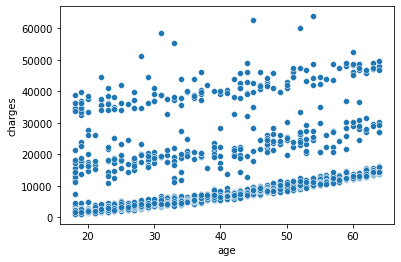

In [4]:
sns.scatterplot(data=df, x="age", y="charges")
plt.show()

In [146]:
df_2 = df.copy()

**TO DO:** Define a new variable that describes the tiers of charges, let's call it `tier`. It is defined as follows:
- `tier 1` if `charges<15000`
- `tier 2` if `charges>=15000` and `charges<33000`
- `tier 3` if `charges>=33000`

**TO DO:** Visualize `charges` vs. `age` using `tier` as a legend.

In [147]:
# Let's define charges tiers
df_2["tier"] = "tier 1"
df_2.loc[(df_2["charges"]>=15000) & (df_2["charges"]<33000), "tier"] = "tier 2"
df_2.loc[df_2["charges"]>=33000, "tier"] = "tier 3"

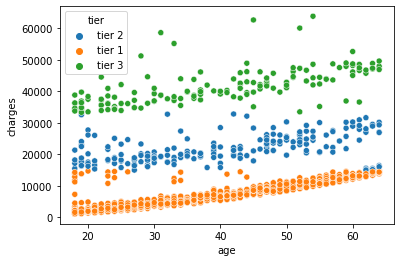

In [85]:
sns.scatterplot(data=df_2, x="age", y="charges", hue="tier")
plt.show()

**Transform charges by substracting the fixed charge associated to each tier**

In [148]:
# Let's define the fixed charge for each tier
fixed_charge_1 = df_2.loc[(df_2["tier"]=="tier 1") & (df_2["age"]==18), "charges"].min()
fixed_charge_2 = df_2.loc[(df_2["tier"]=="tier 2") & (df_2["age"]==18), "charges"].min()
fixed_charge_3 = df_2.loc[(df_2["tier"]=="tier 3") & (df_2["age"]==18), "charges"].min()
df_2.loc[df_2["tier"]=="tier 1", "fixed_charge"] = fixed_charge_1
df_2.loc[df_2["tier"]=="tier 2", "fixed_charge"] = fixed_charge_2
df_2.loc[df_2["tier"]=="tier 3", "fixed_charge"] = fixed_charge_3

In [149]:
# Let's subtract the fixed charge from charges for all tiers
df_2["charges"] = df_2["charges"] - df_2["fixed_charge"]
df_2.drop(columns=["fixed_charge"], inplace=True)

**Visualize the new values of `charges` vs. `age`**

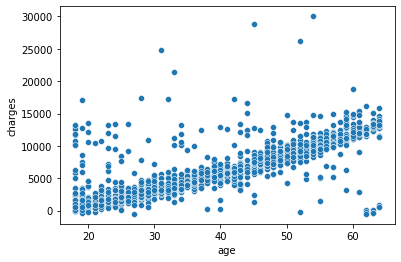

In [57]:
sns.scatterplot(data=df_2, x="age", y="charges")
plt.show()

**Visualize a fitted polynomial to `charges` vs `age`**

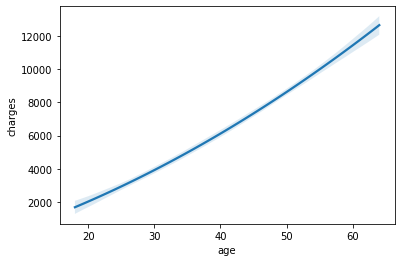

In [58]:
sns.regplot(data=df_2, x="age", y="charges", order=2, scatter=False)
plt.show()

**TO DO:** Based on what we have seen previously, create a new feature that accounts for the order of the polynomial that describes the relationship between `charges` and `age`

In [150]:
# Let's take into account the above observation !
df_2["age_squared"] = df_2["age"]**2

#### Let's train a synthetic data generation model

**TO DO:** Train then sample data from a synthetic data generation model of your choice (`GuassianCopula`, `CTGAN` or `TVAE`) using the new transformed dataset. 

In [151]:
model_gaussian_2 = GaussianCopula()
model_gaussian_2.fit(df_2)

In [152]:
df_gaussian_2 = model_gaussian_2.sample(1400)

**Transform the real data back to its original form:** Add the corresponding fixed charge to the charges of each tier in the real data

In [154]:
df_2.loc[df_2["tier"]=="tier 1", "fixed_charge"] = fixed_charge_1
df_2.loc[df_2["tier"]=="tier 2", "fixed_charge"] = fixed_charge_2
df_2.loc[df_2["tier"]=="tier 3", "fixed_charge"] = fixed_charge_3
df_2["charges"] = df_2["charges"] + df_2["fixed_charge"]
df_2.drop(columns=["fixed_charge", "age_squared"], inplace=True)

**TO DO:** Transform the synthetic data back

In [153]:
# Let's transform the data back
df_gaussian_2.loc[df_gaussian_2["tier"]=="tier 1", "fixed_charge"] = fixed_charge_1
df_gaussian_2.loc[df_gaussian_2["tier"]=="tier 2", "fixed_charge"] = fixed_charge_2
df_gaussian_2.loc[df_gaussian_2["tier"]=="tier 3", "fixed_charge"] = fixed_charge_3
df_gaussian_2["charges"] = df_gaussian_2["charges"] + df_gaussian_2["fixed_charge"]
df_gaussian_2.drop(columns=["fixed_charge", "age_squared"], inplace=True)

**Visualize the synthetic data**

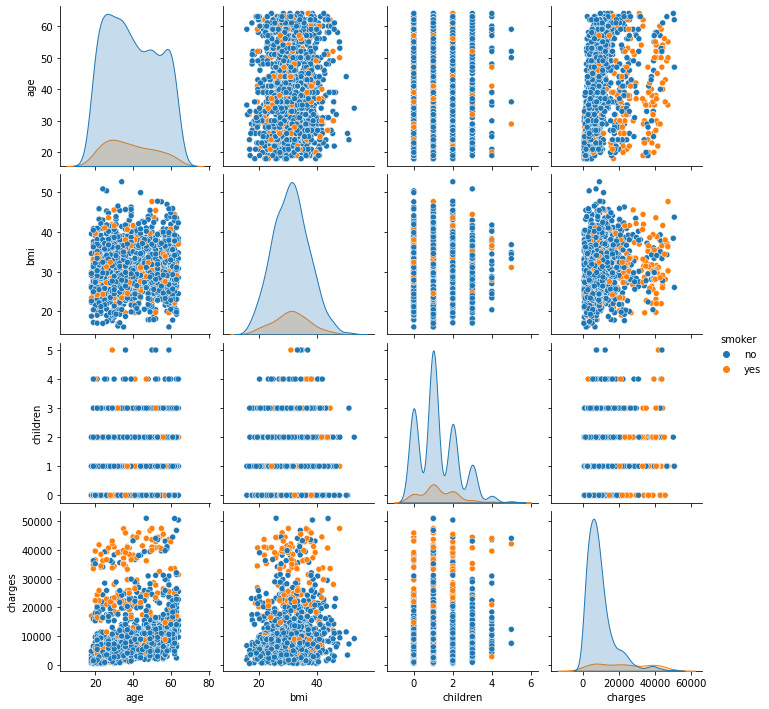

In [173]:
sns.pairplot(data=df_gaussian_2, hue="smoker")
plt.show()

#### Let's evaluate the new generated data

**TO DO:** Evaluate the synthetic data using `sdv.evaluation.evaluate`

In [175]:
columns = ["age", "sex", "bmi", "children", "smoker", "region", "charges"]
real_data = df_2[columns]
synthetic_data = df_gaussian_2[columns]

In [158]:
evaluate(real_data, synthetic_data, aggregate=False)

,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,KSComplement,Inverted Kolmogorov-Smirnov D statistic,0.901864,0.901864,0.0,1.0,MAXIMIZE,None
1,CSTest,Chi-Squared,0.941042,0.941042,0.0,1.0,MAXIMIZE,None


**TO DO:** Evaluate the synthetic data using `sdmetrics.reports.single_table.QualityReport`

Creating report: 100%|██████████| 4/4 [00:00<00:00, 26.81it/s]



Overall Quality Score: 93.09%

Properties:
Column Shapes: 93.3%
Column Pair Trends: 92.88%


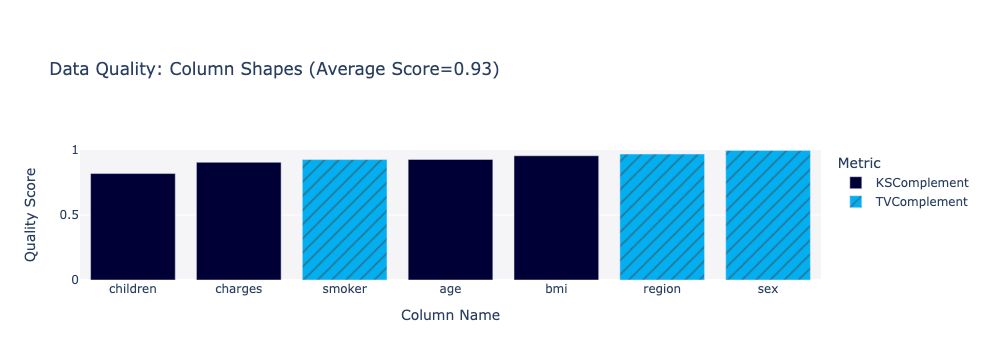

In [159]:
report = QualityReport()
report.generate(real_data, synthetic_data, metadata)
fig = report.get_visualization(property_name='Column Shapes')
fig.show()

**TO DO:** Plot `charges` vs. `age` in the synthetic dataset vs. the real dataset. Let's discuss !

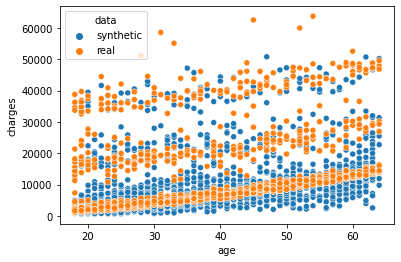

In [160]:
to_plot = df_gaussian_2[["age", "charges"]]
to_plot["data"] = "synthetic"
to_plot = pd.concat([to_plot, df_2[["age", "charges"]]])
to_plot.fillna("real", inplace=True)
sns.scatterplot(data=to_plot, x="age", y="charges", hue="data")
plt.show()

**TO DO:** Visualize individual feature distributions using `get_column_plot`

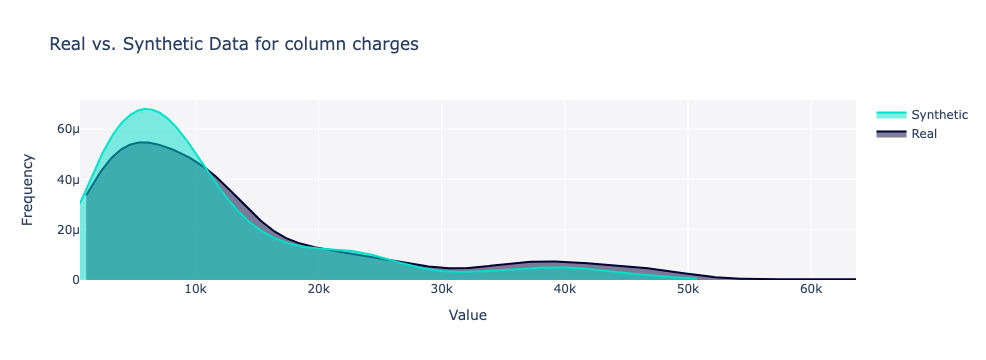

In [177]:
from sdmetrics.reports import utils

fig = utils.get_column_plot(
    real_data=real_data,
    synthetic_data=synthetic_data,
    column_name='charges',
    metadata=metadata
)

fig.show()

In [162]:
report.get_details(property_name='Column Shapes')

,Column,Metric,Quality Score
0,age,KSComplement,0.927608
1,bmi,KSComplement,0.955751
2,children,KSComplement,0.818859
3,charges,KSComplement,0.905240
4,sex,TVComplement,0.996911
5,smoker,TVComplement,0.926645
6,region,TVComplement,0.968657


### Synthetic data generation limitations

- **Quality metrics**: As we saw in this example, the metrics might not accurately reflect the quality of the generated data. It is very important to rely on visualization in order to get a better idea of the quality of the synthetic dataset.
- **Models:** As in every ML problem, selecting the right model is a process that needs to be taken seriously. An essential first step towards selecting a good model is to understand the correlations within the data and define features that will be helpful for the model training. We saw here that without feature engineering, the models aren't very performant and that feature engineering improved the results significantly.
- **Bigger is not always better**: We might easily think that CTGAN would work every single time, but we have seen in this example that a simple model like a Gaussian Copula can work even better than CTGAN if it's coupled with good feature engineering. For small datasets (like the one we tried here), using large models like CTGAN might result in overfitting and poor generalization, which hinders the capabiliy to generate a good synthetic dataset.

- **PII columns**: PII columns need to be processed before training a synthetic data generation model. This is due to the fact that text is considered as a categorical variable and displays it back into the synthetic dataset. So there is a risk of serious data leakage if PII is not treated correctly.

**Let's demonstrate the danger of not treating PII correctly**

**Let's create fake names and add them to the dataset**

In [5]:
from faker import Faker
fake = Faker()

In [20]:
names = [fake.name_male() if row["sex"]=="male" else fake.name_female() for _,row in df.iterrows()]
df["name"] = names

In [22]:
model_gaussian_pii = GaussianCopula()
model_gaussian_pii.fit(df)

In [23]:
df_gaussian_pii = model_gaussian_pii.sample(1400)

**Are any names from the real dataset repeated in the synthetic dataset?**

In [26]:
len(set(df_gaussian_pii["name"]) & set(df["name"]))

875

**How do we fix it?**

In [27]:
model_gaussian_pii_2 = GaussianCopula(anonymize_fields={'name': 'name'})
model_gaussian_pii_2.fit(df)

In [28]:
df_gaussian_pii_2 = model_gaussian_pii_2.sample(1400)

**Does it really work ?**

In [31]:
len(set(df_gaussian_pii_2["name"]) & set(df["name"]))

25